# **GROUP PROJECT**

**Group B:**

1. Irdina Izzati Binti Mohd Rasid (2118986)
2. Qurratu Aini Insyirah Binti Zulkifli (2117184)
3. Nur Syakirah Huda Binti Razali (2112826)
4. Sofea Hani binti Ahmad Shazali (2115668)

In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [3]:
import os

# Function to get image paths and labels
def get_data_labels(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                if image_file.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(label_dir, image_file))
                    labels.append(label)
    return image_paths, labels

# Setting up file paths for training and testing
USER_PATH = "C:/Users/qurra/OneDrive/Desktop/ML/Brain_Tumor/Brain_Tumor"
train_dir = USER_PATH + '/Training/'
test_dir = USER_PATH + '/Testing/'

# Getting data using the above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing training and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


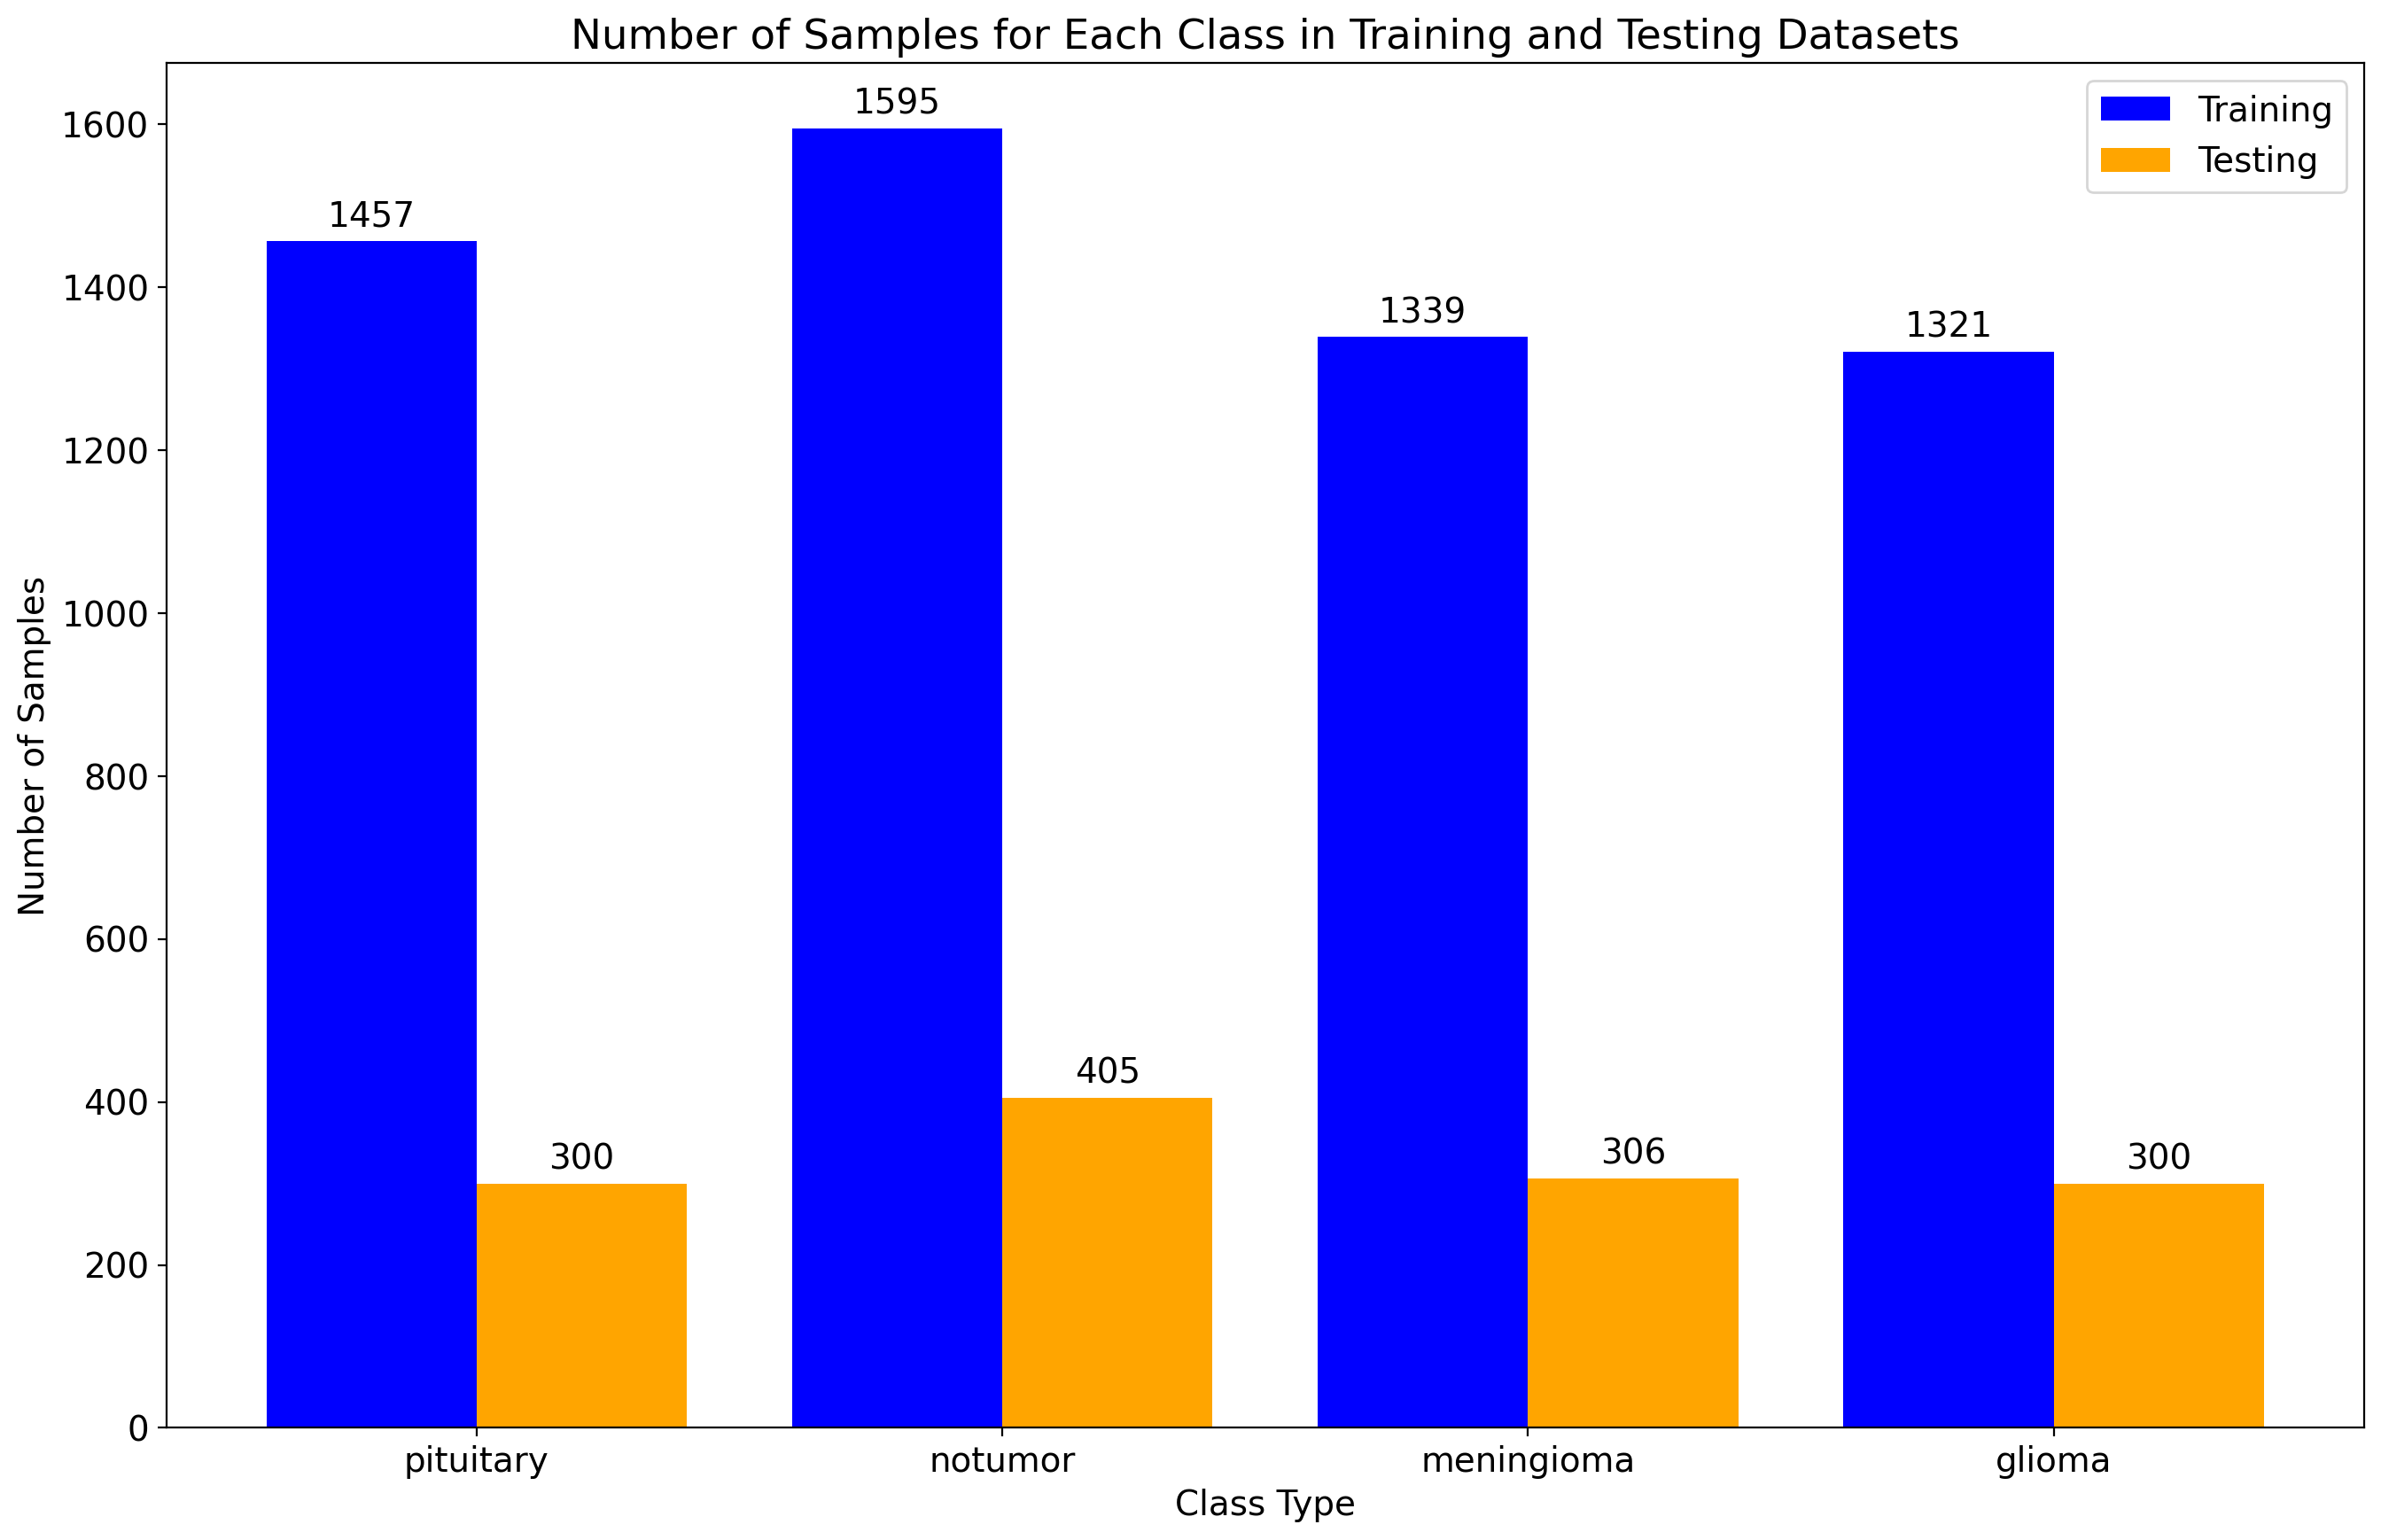

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of samples for each class in the training and testing datasets
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Ensure that all class types are present in the counts, even if some classes have zero samples
train_counts = {cls: train_counts.get(cls, 0) for cls in CLASS_TYPES}
test_counts = {cls: test_counts.get(cls, 0) for cls in CLASS_TYPES}

# Extract the counts for plotting
train_counts_values = [train_counts[cls] for cls in CLASS_TYPES]
test_counts_values = [test_counts[cls] for cls in CLASS_TYPES]

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(16, 10))

# Plot training data
bar_width = 0.4
index = np.arange(N_TYPES)
train_bar = ax.bar(index, train_counts_values, bar_width, label='Training', color='blue')

# Plot testing data
test_bar = ax.bar(index + bar_width, test_counts_values, bar_width, label='Testing', color='orange')

# Adding labels and title
ax.set_xlabel('Class Type')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples for Each Class in Training and Testing Datasets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(CLASS_TYPES)
ax.legend()

# Adding totals on top of each bar
for bar in train_bar:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in test_bar:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Display the plot
plt.show()

x reshaped: (1, 150, 150, 3)


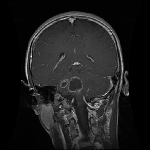

In [5]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

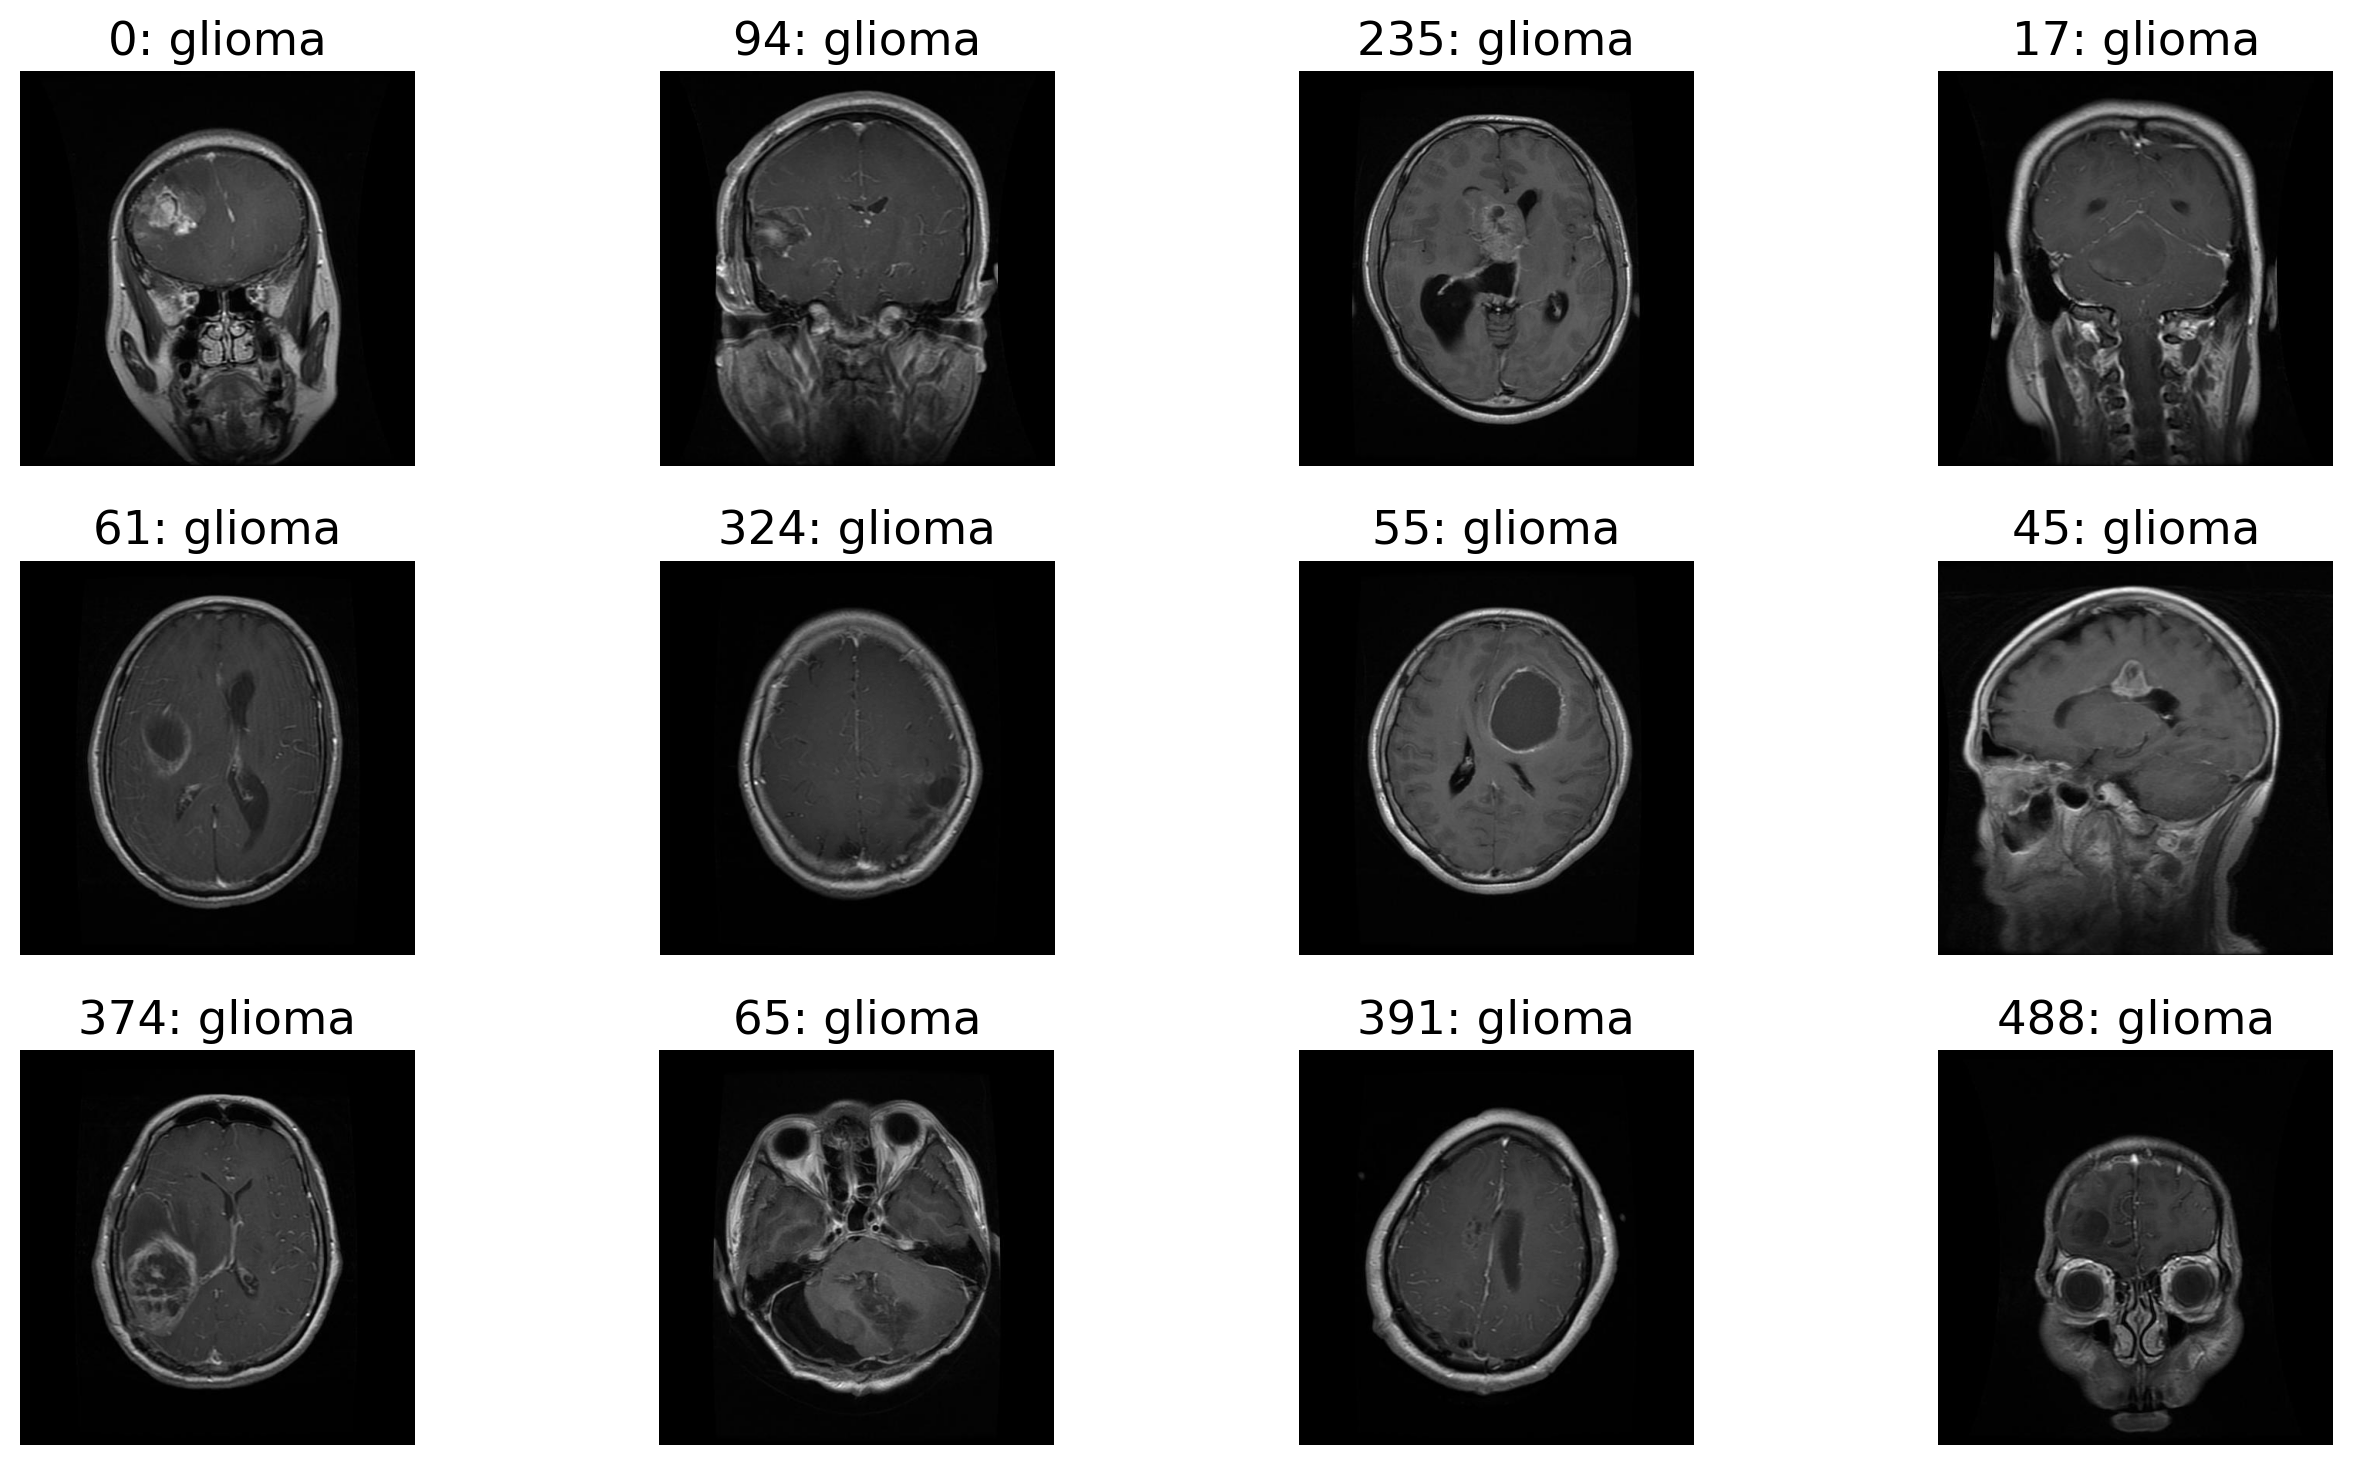

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(image_paths, image_labels, im_size=350, figsize=(13,10), index_list=[]):
    num_images = len(index_list)
    if num_images == 0:
        print("No images to display. Please provide a list of indices.")
        return

    plt.figure(figsize=figsize)
    for i, idx in enumerate(index_list):
        if idx >= len(image_paths):
            print(f"Index {idx} is out of bounds for the dataset.")
            continue
        plt.subplot(num_images // 4 + 1, 4, i + 1)
        img = mpimg.imread(image_paths[idx])
        plt.imshow(img, cmap='gray')
        plt.title(f"{idx}: {image_labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Sample usage of show_images function
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])


Data Preprocessing 

In [7]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [8]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [10]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [11]:
import numpy as np

# Function to extract features and labels from ImageDataGenerator
def extract_features_labels(generator, num_samples, image_size):
    batch_size = generator.batch_size
    features = np.zeros(shape=(num_samples, image_size[0] * image_size[1] * 3))
    labels = np.zeros(shape=(num_samples, len(generator.class_indices)))
    i = 0
    for inputs_batch, labels_batch in generator:
        current_batch_size = inputs_batch.shape[0]
        features[i * batch_size : i * batch_size + current_batch_size] = inputs_batch.reshape(current_batch_size, -1)
        labels[i * batch_size : i * batch_size + current_batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_samples:
            break
    return features, labels

# Number of samples
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Extract features and labels for training and testing data
train_features, train_labels = extract_features_labels(train_generator, num_train_samples, image_size)
test_features, test_labels = extract_features_labels(test_generator, num_test_samples, image_size)

# Convert labels to single class indices
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
# Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=SEED)

# Train the model
dt_model.fit(train_features, train_labels)

# Predict on the test data
test_predictions = dt_model.predict(test_features)

In [14]:
# Evaluate the model
dt_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Decision Tree Accuracy: {dt_accuracy}')
print('Classification Report:')
print(classification_report(test_labels, test_predictions))
print('Confusion Matrix:')
print(confusion_matrix(test_labels, test_predictions))

Decision Tree Accuracy: 0.7353165522501907
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       300
           1       0.57      0.55      0.56       306
           2       0.79      0.88      0.83       405
           3       0.77      0.79      0.78       300

    accuracy                           0.74      1311
   macro avg       0.73      0.72      0.72      1311
weighted avg       0.73      0.74      0.73      1311

Confusion Matrix:
[[201  62  12  25]
 [ 31 169  66  40]
 [ 11  31 356   7]
 [ 15  33  14 238]]


SVM

In [15]:
from sklearn.svm import SVC

# Initialize SVM
svm_model = SVC(kernel='linear')

#Train model
svm_model = svm_model.fit(train_features, train_labels)

# Predict test data
test_predictions = svm_model.predict(test_features)

In [16]:
# Evaluate the model
svm_accuracy = accuracy_score(test_labels, test_predictions)
print(f'SVM Accuracy: {svm_accuracy}')
print('Classification Report:')
print(classification_report(test_labels, test_predictions))
print('Confusion Matrix:')
print(confusion_matrix(test_labels, test_predictions))

SVM Accuracy: 0.7360793287566743
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       300
           1       0.53      0.47      0.50       306
           2       0.80      0.85      0.82       405
           3       0.83      0.91      0.87       300

    accuracy                           0.74      1311
   macro avg       0.72      0.73      0.72      1311
weighted avg       0.73      0.74      0.73      1311

Confusion Matrix:
[[204  74   8  14]
 [ 55 143  73  35]
 [ 14  39 344   8]
 [  7  15   4 274]]


Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
nb_model = nb_model.fit(train_features, train_labels)


# Predict on the test data
test_predictions = nb_model.predict(test_features)

In [18]:
# Evaluate the model
nb_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Naive Bayes Accuracy: {nb_accuracy}')
print('Classification Report:')
print(classification_report(test_labels, test_predictions))
print('Confusion Matrix:')
print(confusion_matrix(test_labels, test_predictions))

Naive Bayes Accuracy: 0.5293668954996186
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.89      0.62       300
           1       0.24      0.17      0.20       306
           2       0.68      0.48      0.56       405
           3       0.75      0.60      0.67       300

    accuracy                           0.53      1311
   macro avg       0.54      0.54      0.51      1311
weighted avg       0.54      0.53      0.51      1311

Confusion Matrix:
[[266  12   0  22]
 [144  53  93  16]
 [ 56 132 196  21]
 [ 92  28   1 179]]


CNN

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [20]:
# Create an instance of the CNN model
input_shape = (150, 150, 3)  # image size and channels
num_classes = len(CLASS_TYPES)  # number of output classes
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display model summary
cnn_model.summary()

C:\Users\qurra\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cnn_model.fit(train_generator,
         steps_per_epoch=steps_per_epoch,
         epochs=epochs,
         validation_data=test_generator,
         validation_steps=validation_steps)

Epoch 1/40


C:\Users\qurra\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 135s 720ms/step - accuracy: 0.5591 - loss: 0.9585 - val_accuracy: 0.6508 - val_loss: 0.9618
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.5895 - val_accuracy: 0.6774 - val_loss: 0.9340


c:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.8061 - loss: 0.5057 - val_accuracy: 0.7305 - val_loss: 0.6203
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.8438 - loss: 0.4075 - val_accuracy: 0.8710 - val_loss: 0.4876
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 450ms/step - accuracy: 0.8515 - loss: 0.3829 - val_accuracy: 0.8359 - val_loss: 0.4012
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8750 - loss: 0.3955 - val_accuracy: 0.8710 - val_loss: 0.2829
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 454ms/step - accuracy: 0.8652 - loss: 0.3329 - val_accuracy: 0.8461 - val_loss: 0.3555
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9375 - loss: 0.2069 - val_accuracy: 0.9677 - val_loss: 0.0781
Epoch 9/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 84s 460ms/step - accuracy: 0.8982 - loss: 0.2585 - val_accuracy: 0.8672 - val_loss: 0.3684
Epoch 10/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.8125 - loss: 0.43

In [22]:
# Make predictions on the test data
test_predictions = cnn_model.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model
cnn_accuracy = accuracy_score(test_labels, test_predictions)
print(f'CNN Accuracy: {cnn_accuracy}')
print('Classification Report:')
print(classification_report(test_labels, test_predictions))
print('Confusion Matrix:')
print(confusion_matrix(test_labels, test_predictions))

CNN Accuracy: 0.9534706331045004
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       300
           1       0.89      0.94      0.91       306
           2       0.95      1.00      0.97       405
           3       0.99      0.97      0.98       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311

Confusion Matrix:
[[268  27   5   0]
 [  1 287  14   4]
 [  0   0 405   0]
 [  0   8   2 290]]


CNN-LSTM

In [24]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape

In [25]:
# Define the CNN-LSTM model
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # CNN layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
   # Flatten and reshape for LSTM
    model.add(Flatten())
    model.add(Reshape((128, 49)))  # Reshape to (time_steps, features)
    
    # LSTM layer
    model.add(LSTM(128, return_sequences=False))  # LSTM layer with 128 units
    
    # Dense layers for classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model
  
# Create an instance of the CNN-LSTM model
input_shape = (150, 150, 3)  # image size and channels
num_classes = len(CLASS_TYPES)  # number of output classes
cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes)

C:\Users\qurra\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [26]:
# Compile the model
cnn_lstm_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [27]:
# Display model summary
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 49)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        91,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,996 (1.33 MB)

 Trainable params: 348,996 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
cnn_lstm_model.fit(train_generator,
         steps_per_epoch=steps_per_epoch,
         epochs=epochs,
         validation_data=test_generator,
         validation_steps=validation_steps)

Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 420ms/step - accuracy: 0.4249 - loss: 1.1875 - val_accuracy: 0.6516 - val_loss: 0.8840
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.8125 - loss: 0.5574 - val_accuracy: 0.6452 - val_loss: 0.9154
Epoch 3/40


c:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 74s 408ms/step - accuracy: 0.6797 - loss: 0.7701 - val_accuracy: 0.6250 - val_loss: 0.9858
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.8438 - loss: 0.4434 - val_accuracy: 0.7742 - val_loss: 0.5933
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 75s 416ms/step - accuracy: 0.7474 - loss: 0.6359 - val_accuracy: 0.7359 - val_loss: 0.6459
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.7812 - loss: 0.7141 - val_accuracy: 0.9355 - val_loss: 0.3846
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 77s 426ms/step - accuracy: 0.7701 - loss: 0.5791 - val_accuracy: 0.7477 - val_loss: 0.6053
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.7188 - loss: 0.7911 - val_accuracy: 0.9355 - val_loss: 0.3593
Epoch 9/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 443ms/step - accuracy: 0.7736 - loss: 0.5736 - val_accuracy: 0.6461 - val_loss: 1.0341
Epoch 10/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.8125 - loss: 0.4154 - val_ac

In [29]:
# Make predictions on the test data
test_predictions = cnn_lstm_model.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step


In [30]:
# Evaluate the model
cnn_lstm_accuracy = accuracy_score(test_labels, test_predictions)
print(f'CNN-LSTM Accuracy: {cnn_lstm_accuracy}')
print('Classification Report:')
print(classification_report(test_labels, test_predictions))
print('Confusion Matrix:')
print(confusion_matrix(test_labels, test_predictions))

CNN-LSTM Accuracy: 0.8199847444698704
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       300
           1       0.75      0.61      0.67       306
           2       0.78      1.00      0.88       405
           3       0.92      0.88      0.90       300

    accuracy                           0.82      1311
   macro avg       0.83      0.81      0.81      1311
weighted avg       0.82      0.82      0.81      1311

Confusion Matrix:
[[220  62  14   4]
 [ 21 187  78  20]
 [  0   0 405   0]
 [ 15   1  21 263]]


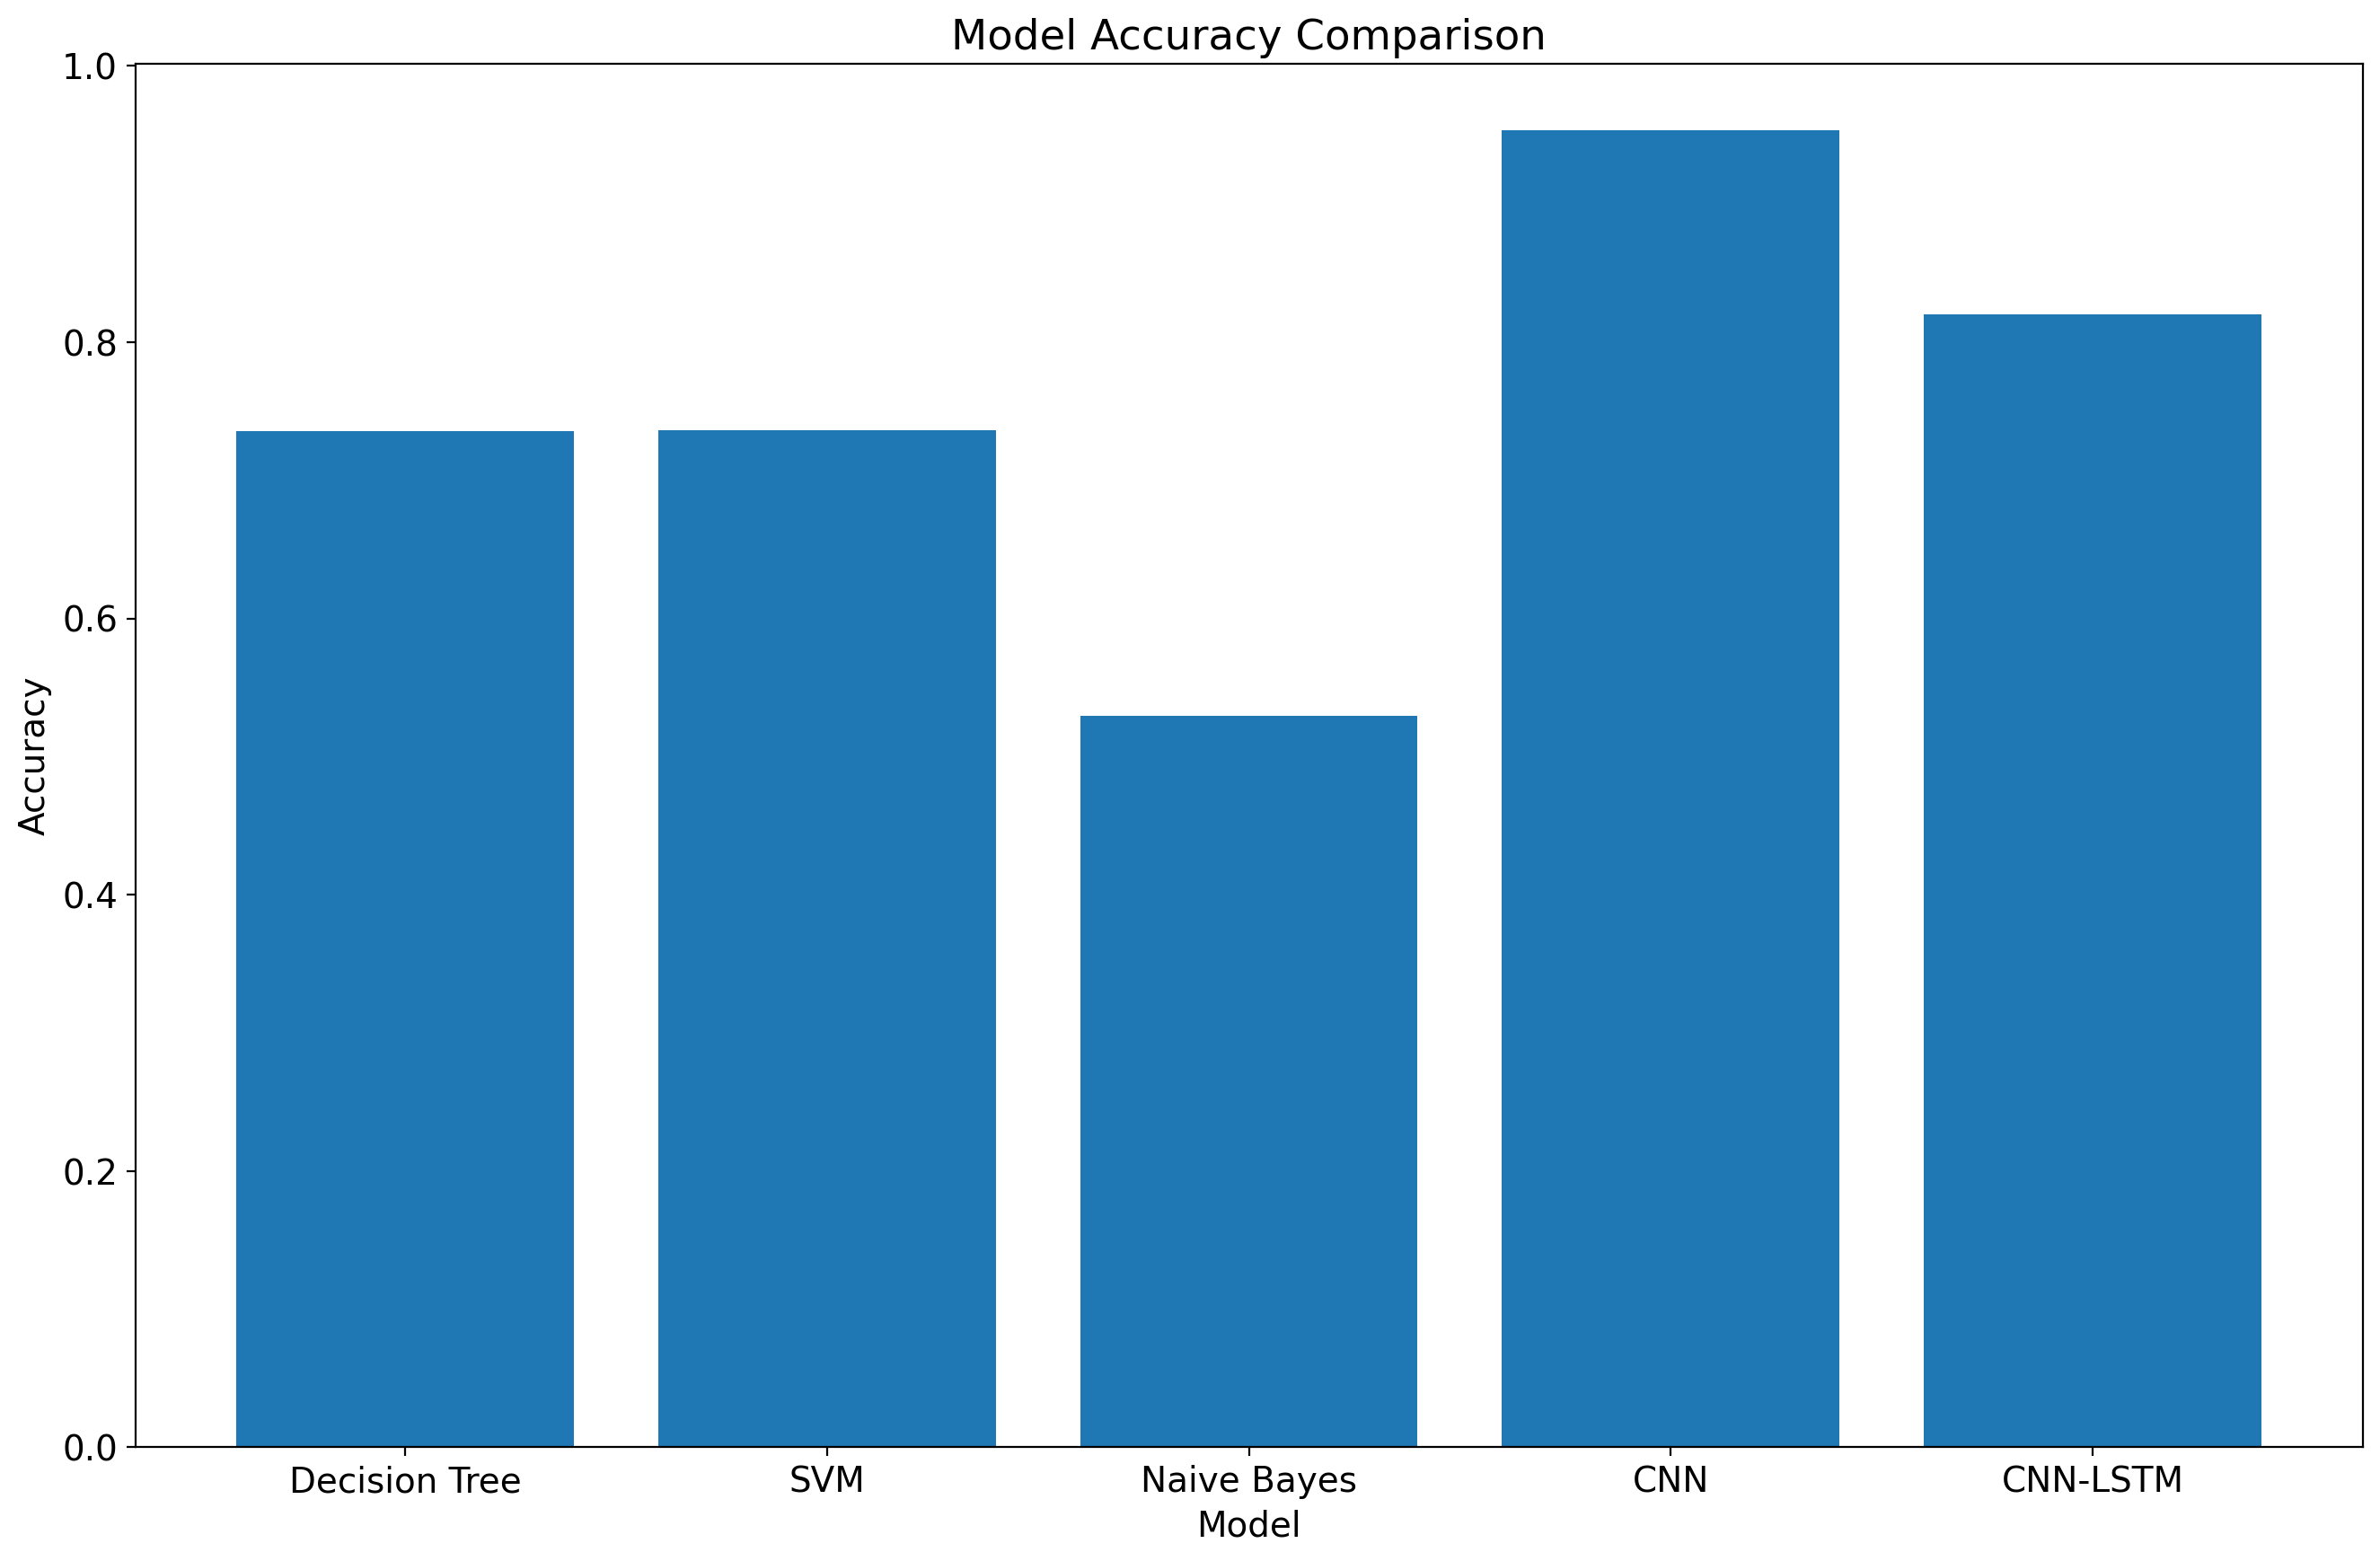

In [31]:
import matplotlib.pyplot as plt

# Define the accuracy values
accuracies = {
    'Decision Tree': dt_accuracy,
    'SVM': svm_accuracy,
    'Naive Bayes': nb_accuracy,
    'CNN': cnn_accuracy,
    'CNN-LSTM': cnn_lstm_accuracy
}

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a bar chart
ax.bar(accuracies.keys(), accuracies.values())

# Set title and labels
ax.set_title('Model Accuracy Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()